# Biodiversity of Williamson County, Texas

## Project Overview
With this notebook we will be taking a look at some biological observations made by citizen scientists in Williamson County Texas, with the goal of creating a Random Forest model that can predict the seasonal changes in biodiversity within the county.

#### Why?
Williamson County has experienced a boom in population over the last few years and with an increase in development, there is potential for a decrease in biodiversity. Groups such as the Texas Master Naturalists and the Native Plant Society have put forth growing efforts to rescue and rehabilitate native habitats. The goal of this project is to see how the biodiversity has been affected.

[Project Repository](https://github.com/DillonKyle/csca-5622-final)

### Install the necessary Python Libraries

In [17]:
pip install numpy pandas matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


### Import the python libraries we will use

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

## Data
The dataset we are using comes from inaturalist.com and contains 155,942 observations in Williamson County, Texas from 2020-2023.

iNaturalist is an image and location based specimen identification platform and since many species require dissection or microscopy to identify, there is a lack of available species names. Due to this, we are going one step up and use the genus as the main descriptor for this project.

This date range was chosen as it is the most complete and accurate range. During covid of 2020, iNaturalist experienced a major increase in users. The previous years show significantly less observations and were omitted from the dataset.

This tabular dataset is in CSV format and contains the observed dates and various taxonomic descriptors. The two values of most interest are 'observed_on' and 'taxon_genus_name'

### Cleaning
The data had to be sorted first by 'iconic_taxon_name' and reviewed to ensure that the data had not been shifted for a record (some records would have an extra blank field that would shift some values to the next column; these were manually corrected)

The data was then sorted by the 'taxon_genus_name' and all records with empty values were removed

Due to the messy nature of the original data, the majority of data cleaning was performed in a csv editor.

### Load the dataset and preprocess the datetime values
When we load the dataset, we drop any rows with null values in the 'taxon_genus_name' column in case any were missed in the manual cleaning and verify that this column has no null or empty records.

We then fix clean the 'observed_on' value, converting it to a datetime and splitting it into two new columns for Year' and 'Month'

In [3]:
data_path = 'data.csv'
data = pd.read_csv(data_path)

data = data.dropna(subset=['taxon_genus_name'])
row_count = data.shape[0]
print("Number of records: ", row_count)

valid_values = data['taxon_genus_name'].apply(lambda x: x is not None and x != '')
valid_values.sum()
print("No null or empty strings in 'taxon_genus_name'? ", valid_values.sum() == row_count)

data['observed_on'] = pd.to_datetime(data['observed_on'])
data['year'] = data['observed_on'].dt.year
data['month'] = data['observed_on'].dt.month

Number of records:  155942
No null or empty strings in 'taxon_genus_name'?  True


## Exploratory Data Analysis
First we will take a look at a view of the monthly observation count, where we can observe the variable trend in the number of observations throughout the year.


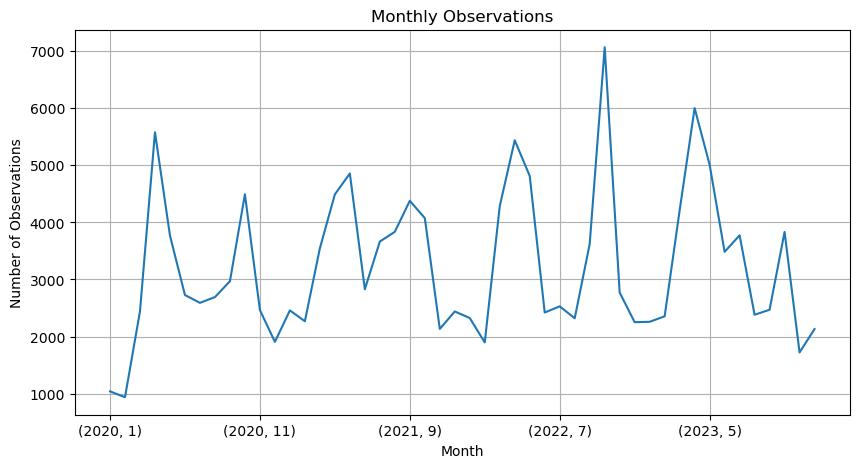

In [4]:
monthly_counts = data.groupby(['year', 'month']).size()

plt.figure(figsize=(10, 5))
monthly_counts.plot(title='Monthly Observations')
plt.ylabel('Number of Observations')
plt.xlabel('Month')
plt.grid(True)
plt.show()


Next we can look at the total observations per genus. This just shows us a quick view of how some genuses may dominate the observation pool.

With this dataset there are some dominating genuses, but the overall number of genuses observered, and the steady decrease (after the dominating drop) gives us confidence that the dataset will produce a quality assessment of the biodiversity. 

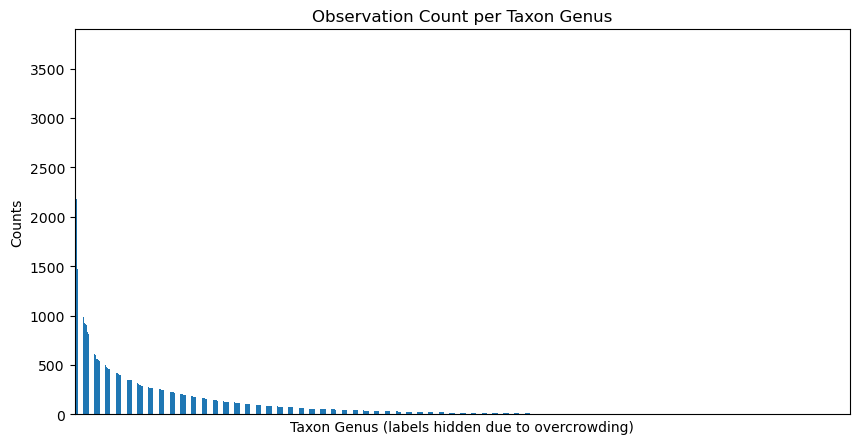

In [5]:
taxon_counts = data['taxon_genus_name'].value_counts()
taxon_counts.plot(kind='bar', figsize=(10, 5), title='Observation Count per Taxon Genus')
plt.ylabel('Counts')
plt.xlabel('Taxon Genus (labels hidden due to overcrowding)')
plt.xticks([])
plt.show()


Lastly we will show the Shannon Diversity Index over time.

The shannon diversity index takes all of the species in a sampled region and provides a score that conveys the biodiversity of the sample.

In [6]:
def calculate_shannon_index(df):
    """ Calculate Shannon Diversity Index for a DataFrame """
    species_counts = df['taxon_genus_name'].value_counts()
    unique_genus = df['taxon_genus_name'].nunique()
    total = species_counts.sum()
    proportions = species_counts / total
    shannon_index = -np.sum(proportions * np.log(proportions))
    
    # Return both Shannon index and the species counts in a Series
    return pd.Series({
        'shannon_index': shannon_index,
        'observations': total,
        'unique_genus': unique_genus
    })
  
monthly_data = data.groupby(['year', 'month']).apply(calculate_shannon_index)
monthly_data.reset_index(inplace=True)

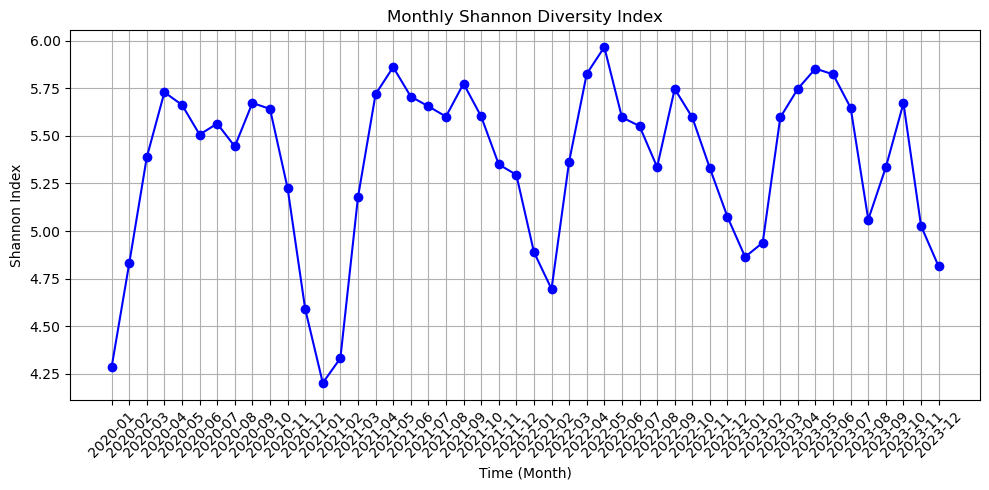

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_data['shannon_index'], marker='o', linestyle='-', color='b')
plt.title('Monthly Shannon Diversity Index')
plt.ylabel('Shannon Index')
plt.xlabel('Time (Month)')
plt.xticks(ticks=range(len(monthly_data)), labels=[f'{y}-{m:02d}' for y, m in zip(monthly_data['year'], monthly_data['month'])], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### EDA Conclusion
In the SDI plot, we are able to see a trend in the biodiversity that aligns with our total observation chart. Note how the number of observations and the SDI decreases in the colder months. We could hypothesize that this is due to the colder temperatures causing a decrease in the observed biodiversity.

## Analysis
For the analysis of this project, we will be using a Random Forest Regression model.

This model is chosen due to its robustness to colineararity and ability to capture non-linear interactions.

When we loaded the dataset, we engineered the 'year' and 'month' features from our 'observed_on' value to add temporal aspects to our dataset. We then calculated the 'shanon_index', 'observations', and 'unique_genus' columns to our dataset when we calculated the Shannon Diversity Index during our EDA.

### Data Split
We will measure the 'year', 'month', 'observations', and 'unique_genus' columns against our 'shannon_index' column for our model.

In [8]:
X = monthly_data[['year', 'month', 'observations', 'unique_genus']]
y = monthly_data['shannon_index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Tuning Parameters
To assess which parameters to use for our Random Forest Regressor, we will utilize the GridSearchCV and an object containing our list of parameters.
This will provid us with the best parameters to use in our model as well as a cross-validation score.

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [50, 100, 200]
}
clf = RandomForestRegressor()

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: ",abs(grid_search.best_score_))

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score:  0.02044193950606109


### Train a Random Forest model to predict the Shannon Diversity Index
Now we will input the best values from the section above to create and train our model and then gauge the importance of our features.

In [10]:
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=2,
    min_samples_split=2,
    random_state=42        
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

To gauge the importance of a feature we will use the 'feature_importance_' method and output its results.

We can see that the 'unique_genus' is the most important feature with an importance of ~0.855

In [11]:
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

print("Feature Importance from Random Forest:")
print(feature_importance)

Feature Importance from Random Forest:
unique_genus    0.855250
observations    0.103628
month           0.021759
year            0.019363
dtype: float64


## Results

### Evaluation
Previously, we evaluated a series of parameters to optimize our model, viewed the best cross validation score, and viewed the importance of its features. Now we will view some more metrics to gauge the quality of our model.

Our MSE, RMSE, and MAE are all low and our R2 score is fairly high, giving us confidence that the parameters generated from our grid search is producing an accurate model.

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared (R^2):", r2)

Mean Squared Error (MSE): 0.02956880667207985
Root Mean Squared Error (RMSE): 0.1719558276769934
Mean Absolute Error (MAE): 0.10353053457893849
R-squared (R^2): 0.8883614182242856


To get another view of our model performance, we can analyze the residuals by plotting them against predicted values and viewing their frequency

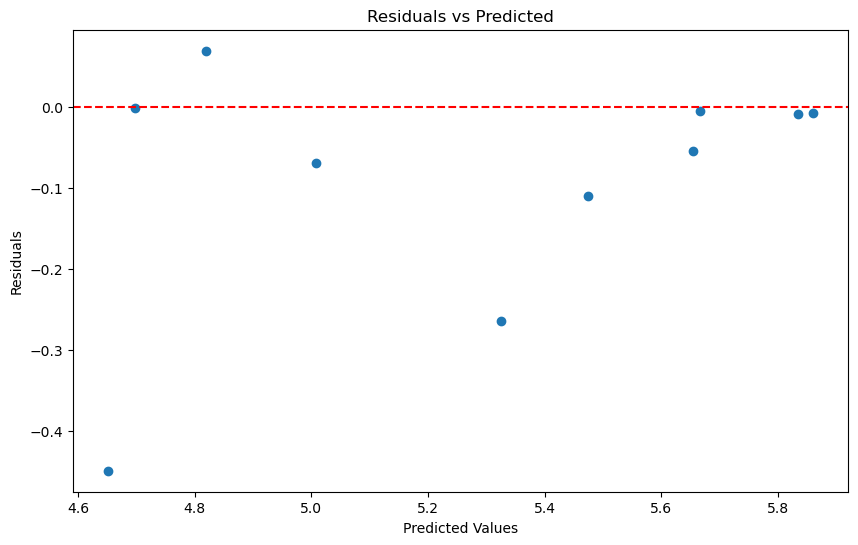

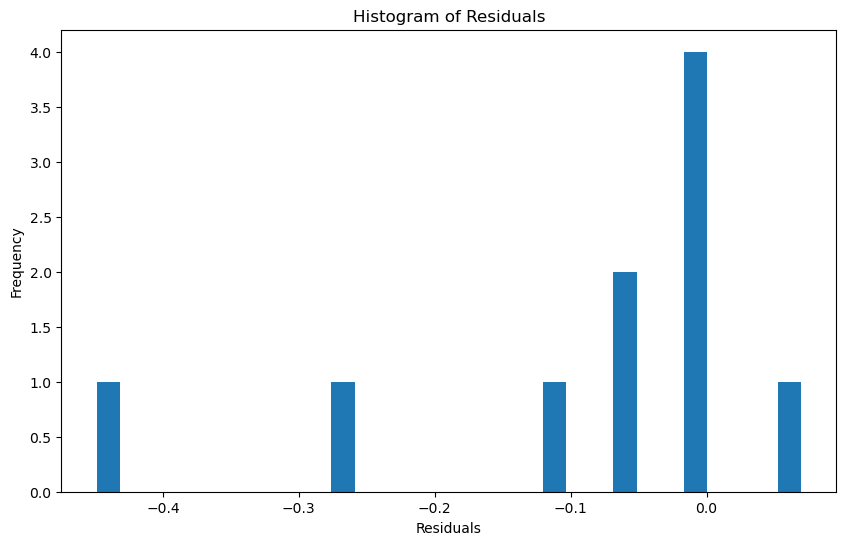

In [13]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


Due to the absence of any extreme residuals and the low frequency of the highest residuals, we gain more confidence in our model.

### Final Plot

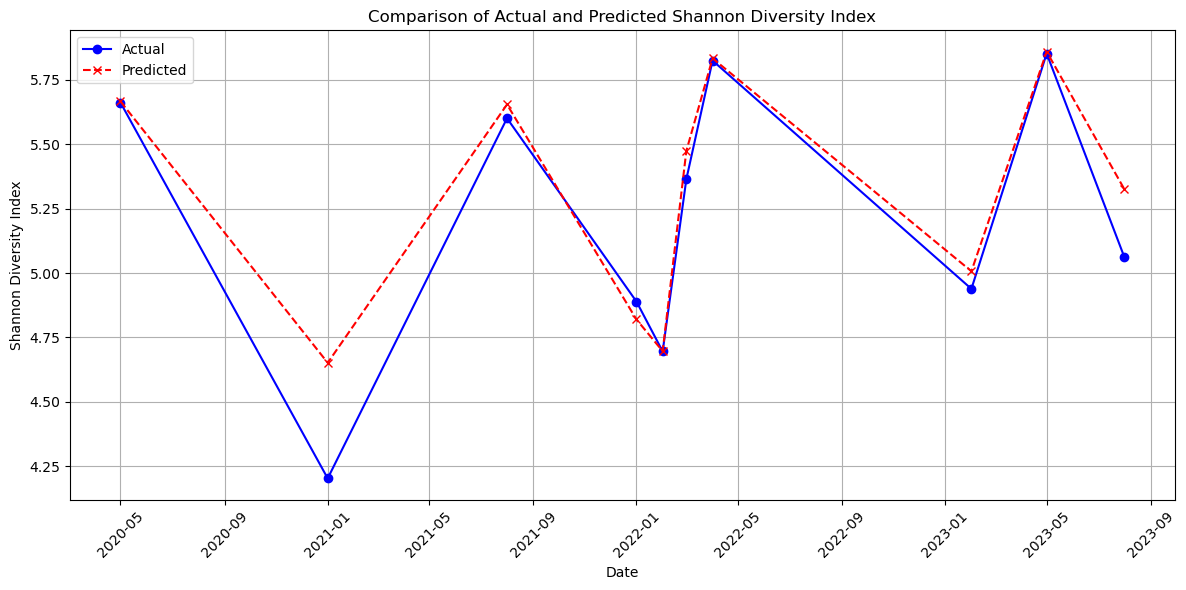

In [14]:
results_df = pd.DataFrame({
    'Year': X_test['year'],
    'Month': X_test['month'],
    'Actual': y_test,
    'Predicted': y_pred
})

results_df['Date'] = pd.to_datetime(results_df[['Year', 'Month']].assign(DAY=1))

results_df.sort_values('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual', marker='o', color='blue')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted', linestyle='--', marker='x', color='red')
plt.title('Comparison of Actual and Predicted Shannon Diversity Index')
plt.xlabel('Date')
plt.ylabel('Shannon Diversity Index')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion
With this model, we can see a variable trend where the SDI decreases in the winter months (showing a decrease in biodiversity) and an increase in the spring (showing an increase in biodiversity). The model also shows a steady increase in the min, max SDI telling us that Williamson County is experiencing a growth in biodiversity. 

Our model's predictions are tracking the observed data well and based on the metrics we produced from the model we can be confident that any further predictions we seek to calculate will be accurate.

When working through this project, the biggest hurdle was feature engineering. I first ran the model without introducing any new features (other than 'year', 'month' and 'shannon_index' which were all crucial). The output of this was acceptable, but I then attempted to include a total observations per month but saw a signifanct increase in error. I then created the unique_genus column and saw a noticable improvement and kept that feature in the model.

If I were to work on a project like this again, I would seek to add a better range of parameters for my grid search and look into other models that I could add in the mix.